In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import norm

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc,plot_confusion_matrix,precision_recall_curve, accuracy_score,roc_auc_score

### Data Cleaning

In [3]:
test_results=pd.read_csv('test_results.csv')
user_table=pd.read_csv('user_table.csv')

In [4]:
test_data=test_results.merge(user_table, on='user_id')

In [5]:
test_data['time']=pd.to_datetime(test_data['timestamp'], format='%Y-%m-%d %H:%M:%S',errors='coerce')

In [6]:
test_data.dropna(axis='rows',inplace=True)

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266656 entries, 0 to 275615
Data columns (total 13 columns):
user_id             266656 non-null int64
timestamp           266656 non-null object
source              266656 non-null object
device              266656 non-null object
operative_system    266656 non-null object
test                266656 non-null int64
price               266656 non-null int64
converted           266656 non-null int64
city                266656 non-null object
country             266656 non-null object
lat                 266656 non-null float64
long                266656 non-null float64
time                266656 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 28.5+ MB


In [8]:
test_data['weekday']= test_data['time'].apply(lambda x: x.weekday())
test_data['hour']= test_data['time'].apply(lambda x: x.hour)
test_data.drop(['timestamp'], axis=1,inplace=True)
test_data.head()

,user_id,source,device,operative_system,test,price,converted,city,country,lat,long,time,weekday,hour
0,604839,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,2015-05-08 03:38:34,4,3
1,624057,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,2015-05-10 21:08:46,6,21
2,317970,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,2015-04-04 15:01:23,5,15
3,685636,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,2015-05-07 07:26:01,3,7
4,820854,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,2015-05-24 11:04:40,6,11


In [9]:
control=test_data[test_data.price==39]
test=test_data[test_data.price==59]

In [10]:
n_control=len(control)
n_control

170563

In [11]:
n_test=len(test)
n_test

96093

### A/B Testing

#### Test 1:

H0: The test and control group has the same conversion rate

H1: The test and control group has different conversion rate

In [12]:
control_conv=sum(control.converted==1)
test_conv=sum(test.converted==1)

In [13]:
p_pool=(control_conv+test_conv)/(n_control+n_test)
se_pool=np.sqrt(p_pool*(1-p_pool)*(1/n_control+1/n_test))

In [14]:
d=(test_conv/n_test)-(control_conv/n_control)
z_score=d/se_pool
z_score

-8.14245432164603

In [15]:
p_value=norm.sf(abs(z_score))*2
p_value

3.87344653481585e-16

#### Test 2:

H0: The test and control group has the same average revenue-per-user

H1: The test and control group has different average revenue-per-user

According to the Central Limit Theorem, the mean of the sampling distribution follows a normal distribution.

In [16]:
control['rev']=control['price']*control['converted']
test['rev']=test['price']*test['converted']

/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ruoqigao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
control_rev=sum(control['rev'])
test_rev=sum(test.rev)

In [18]:
control_rev_per_user=control_rev/n_control
test_rev_per_user=test_rev/n_test

In [19]:
s_control=np.var(control['rev'])/n_control
s_test=np.var(test['rev'])/n_test

In [20]:
d=test_rev_per_user-control_rev_per_user
s_pool=np.sqrt(s_control+s_test)

In [21]:
z_score=d/s_pool
z_score

5.088635145795648

In [22]:
p_value=norm.sf(abs(z_score))*2
p_value

3.606497208494223e-07

#### Conclusion: 

From the A/B test result, we found that we could significantly reject both null hypothesis. The conversion rate of the test set is significantly lower than the control set, while the average revenue per user of the test set is significantly higher than the control set. If the objective of the company is to increase revenue, then it should choose to sell the software at \\$59. If the obejective is to expand the market share and sell more products, the price should be set at \\$39.

#### Length of the experiment

We would want the experiment to run long enough to have enough statistical power to make a conclusion by calculating the required sample size before the experiment starts. The industry standard of power is 80%. For a confidence level of 95%, the size could be approximated by $n=16\sigma^2/\delta^2$ where $\sigma$ is the sample standard deviation and $\delta$ is the practical significance level. The test should last for at least a full week abd has at least 100 conversions per variation. The statistical significance should not dictate when to stop the test. Getting a statisically significant result doesn't mean we should stop the test early.

### Data Insights

In [23]:
test_data.groupby(['source'])['user_id'].count().sort_values(ascending=False)

source
direct_traffic     50851
ads-google         49906
ads_facebook       44889
ads_other          25301
seo-google         19520
ads-bing           19286
seo_facebook       17788
friend_referral    17418
seo-other           7818
ads-yahoo           6308
seo-yahoo           5762
seo-bing            1809
Name: user_id, dtype: int64

In [24]:
test_data.groupby(['operative_system'])['user_id'].count().sort_values(ascending=False)

operative_system
windows    84863
iOS        80373
android    63055
mac        21175
other      13682
linux       3508
Name: user_id, dtype: int64

In [25]:
test_data.groupby(['city','test'])['user_id'].count().sort_values(ascending=False).head(15)

city          test
New York      0       16099
              1        8849
Chicago       0        4427
Houston       0        4143
San Antonio   0        2846
Los Angeles   0        2562
Chicago       1        2459
Houston       1        2338
San Jose      0        2059
Indianapolis  0        1975
Jacksonville  0        1836
San Antonio   1        1640
Philadelphia  0        1601
Los Angeles   1        1469
Las Vegas     0        1462
Name: user_id, dtype: int64

In [30]:
X=test_data.drop(['time','converted','user_id'],axis=1)
X=pd.get_dummies(X)
y=test_data.converted

In [31]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state = 0)

In [32]:
gb=GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3).fit(X_train,y_train)
accuracy = gb.score(X_test, y_test) 

In [33]:
gb_pred_prob=gb.predict_proba(X_test)[:,1]
auc=roc_auc_score(y_test,gb_pred_prob)
auc

0.6128569616782372

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, gb_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, gb_pred_prob)

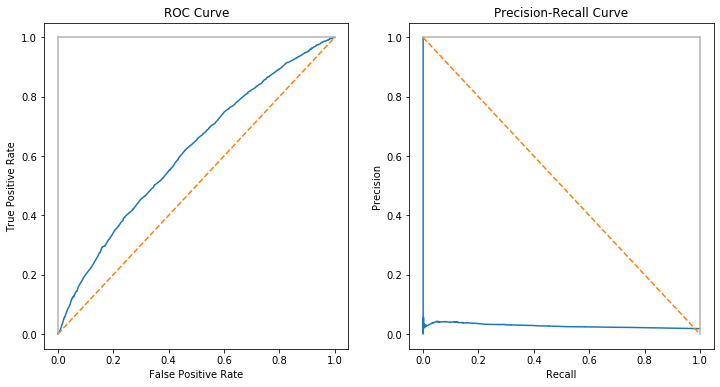

In [35]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("ROC Curve")
plt.plot(fpr,tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.subplot(1,2,2)
plt.title("Precision-Recall Curve")
plt.plot(recall,precision)
plt.plot([1, 0], ls="--")
plt.plot([1, 1], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

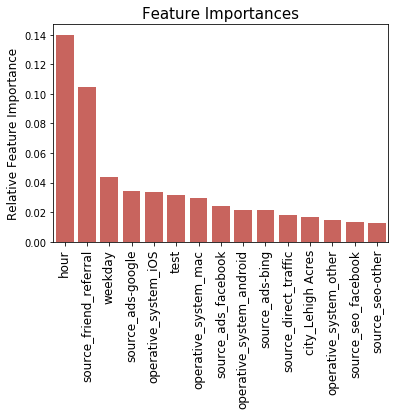

In [36]:
importances = gb.feature_importances_
indices = np.argsort(importances)[::-1]
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
sns.barplot(x=X_train.columns[indices][:15], y=importances[indices][:15], color=sns.xkcd_rgb["pale red"])
plt.title('Feature Importances', fontsize=15)
plt.ylabel('Relative Feature Importance', fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.show()

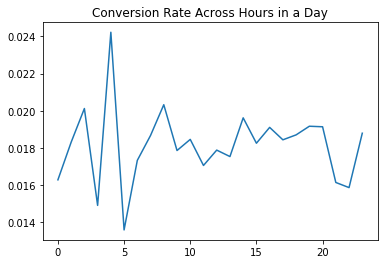

In [37]:
hour_count=test_data.groupby(['hour'])['user_id'].count()
hour_convert=test_data.groupby(['hour'])['converted'].sum()
conv_rate=hour_convert.values/hour_count.values
hour=hour_convert.index
plt.plot(hour,conv_rate)
plt.title('Conversion Rate Across Hours in a Day')
plt.show()

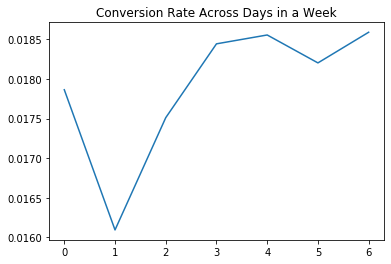

In [38]:
weekday_count=test_data.groupby(['weekday'])['user_id'].count()
weekday_convert=test_data.groupby(['weekday'])['converted'].sum()
conv_rate=weekday_convert.values/weekday_count.values
weekday=weekday_convert.index
plt.plot(weekday,conv_rate)
plt.title('Conversion Rate Across Days in a Week')
plt.show()

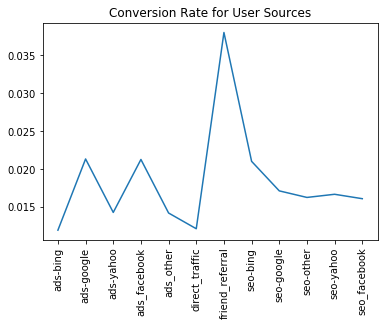

In [39]:
source_count=test_data.groupby(['source'])['user_id'].count()
source_convert=test_data.groupby(['source'])['converted'].sum()
conv_rate=source_convert.values/source_count.values
source=source_convert.index
plt.plot(source,conv_rate)
plt.xticks(rotation=90)
plt.title('Conversion Rate for User Sources')
plt.show()

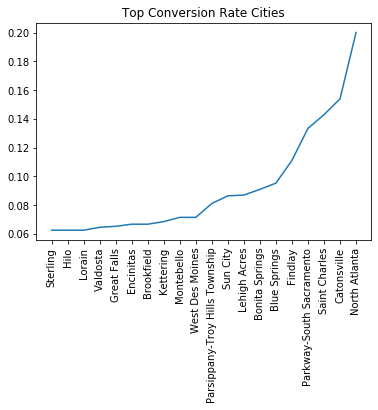

In [40]:
city_count=test_data.groupby(['city'])['user_id'].count()
city_convert=test_data.groupby(['city'])['converted'].sum()
conv_rate=city_convert.values/city_count.values
conv_rate_top20=sorted(city_convert.values/city_count.values)[-20:]
city_top20=city_convert.index[np.argsort(conv_rate)[-20:]]

plt.plot(city_top20,conv_rate_top20)
plt.title('Top Conversion Rate Cities')
plt.xticks(rotation=90)
plt.show()

### Conclusions:

The top features that affect the conversion rates are hour, day of the week and source of the user. The price is not one of the top importance features.

In order to increase conversion rate, the company should attract users to the site through marketing channels on days/hours when they're most likely to convert. It would be useful if the company could analyze and find out the reasons behind the top conversion days/hours, so that they'll know the difference is not caused by logging error.

Friends referrals is another important factor that cause a user to convert. To monetize on the finding, the company could offer discount/coupon to people who refer their friends to the site, in order to acquire user quickly and create virality in growth.

The cities with top conversion rates are not the cities with the highest number of users. It shows that there's great opportunity for the product to expand into cities that people need the product the most. Using the result the analyse combined with in-depth market segment analysis would help the company decide its growth strategy.